In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data  import random_split, Subset
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import matplotlib.pyplot as plt
import time
import copy

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

%load_ext autoreload
%autoreload 2

In [2]:
from model.data_loader import *

PHOTOSHOPS_FULL ='data/photoshops_resized'
ORIGINALS_FULL ='data/originals_resized'


In [3]:
master_dataset = PhotoshopDataset(ORIGINALS_FULL, PHOTOSHOPS_FULL)
print(len(master_dataset))

20759


Change device to GPU if available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Create train, val, splits for full learning 

This is the dataset that will be used for final learning

In [5]:
random.seed(42)

n = len(master_dataset)
n_test= int( n * .15 )  # number of test/val elements
n_val = n_test
n_train = n - 2 * n_test

train_set, val_set, test_set = random_split(master_dataset, (n_train, n_val, n_test))

In [6]:
print (len(train_set))
train_set.transform = data_transforms['train']
print (len(val_set))
val_set.transform = data_transforms['val']
print (len(test_set))
test_set.transform = data_transforms['val']

14533
3113
3113


### Create train, val, splits for dev

This is the dataset that will be used for development i.e 10% of master data

In [36]:
n_train_dev = int( n_train * .1 )
n_test_dev= int( n_test * .1 )  
n_val_dev = int( n_val * .1)


train_set_dev = Subset(train_set, range(n_train_dev))
val_set_dev = Subset(val_set,range(n_val_dev))
test_set_dev = Subset(test_set, range(n_test_dev))

In [37]:
print (len(train_set_dev))
print (len(val_set_dev))
print (len(test_set_dev))

1453
311
311


### Create data loaders for dev sets

Used to load data. 

In [38]:
full_dataloaders = {
    'train' : DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4),
    'val' : DataLoader(val_set, batch_size=128, shuffle=True, num_workers=4),
    'test' : DataLoader(test_set, batch_size=128, shuffle=True, num_workers=4),
}

In [39]:
dev_dataloaders = {
    'train' : DataLoader(train_set_dev, batch_size=8, shuffle=True, num_workers=2),
    'val' : DataLoader(val_set_dev, batch_size=8, shuffle=True, num_workers=2),
    'test' : DataLoader(test_set_dev, batch_size=8, shuffle=True, num_workers=2)
}

### Importing the InceptionV3 Classifier

Classifier is a finetuned InceptionV3 model

In [40]:
from model.inception_net import inception_classifier

In [41]:
inception_model, inception_hist = inception_classifier(dev_dataloaders)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias
Epoch 0/24
----------
train Loss: 0.9964 Acc: 0.5492
val Loss: 0.7045 Acc: 0.5466

Epoch 1/24
----------
train Loss: 1.0080 Acc: 0.5609
val Loss: 0.7208 Acc: 0.5434

Epoch 2/24
----------
train Loss: 0.9894 Acc: 0.5850
val Loss: 0.6929 Acc: 0.5756

Epoch 3/24
----------
train Loss: 0.9572 Acc: 0.6050
val Loss: 0.6862 Acc: 0.6013

Epoch 4/24
----------
train Loss: 0.9275 Acc: 0.6118
val Loss: 0.6684 Acc: 0.6141

Epoch 5/24
----------
train Loss: 0.9438 Acc: 0.6132
val Loss: 0.6911 Acc: 0.5820

Epoch 6/24
----------
train Loss: 0.9165 Acc: 0.6077
val Loss: 0.6874 Acc: 0.5852

Epoch 7/24
----------
train Loss: 0.9070 Acc: 0.6228
val Loss: 0.7024 Acc: 0.5884

Epoch 8/24
----------
train Loss: 0.9102 Acc: 0.6167
val Loss: 0.6684 Acc: 0.6141

Epoch 9/24
----------
train Loss: 0.9172 Acc: 0.6008
val Loss: 0.6926 Acc: 0.5981

Epoch 10/24
----------
train Loss: 0.9239 Acc: 0.6304
val Loss: 0.6532 Acc: 0.6238

Epoch

### Visualizing the results

We will plot the results

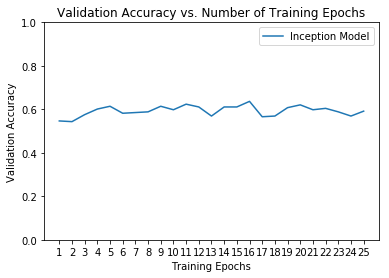

In [42]:
inception_ohist = [h.cpu().numpy() for h in inception_hist]
num_epochs = 25
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),inception_ohist,label="Inception Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

### Importing the CNN Model

Classifier is a simple 3 layer CNN model

In [43]:
from model.cnn import cnn_classifier

In [46]:
cnn_model, cnn_hist = cnn_classifier(dev_dataloaders)

Params to learn:
	 layer1.0.weight
	 layer1.0.bias
	 layer1.1.weight
	 layer1.1.bias
	 layer2.0.weight
	 layer2.0.bias
	 layer2.1.weight
	 layer2.1.bias
	 layer3.0.weight
	 layer3.0.bias
	 layer3.1.weight
	 layer3.1.bias
	 fc.weight
	 fc.bias
Epoch 0/24
----------
train Loss: 43.2003 Acc: 0.4942
val Loss: 51.8745 Acc: 0.4920

Epoch 1/24
----------
train Loss: 24.5311 Acc: 0.5086
val Loss: 7.6891 Acc: 0.4984

Epoch 2/24
----------
train Loss: 6.5834 Acc: 0.4907
val Loss: 2.9968 Acc: 0.4984

Epoch 3/24
----------
train Loss: 2.7464 Acc: 0.5224
val Loss: 2.4398 Acc: 0.4984

Epoch 4/24
----------
train Loss: 1.1568 Acc: 0.4811
val Loss: 0.8334 Acc: 0.4984

Epoch 5/24
----------
train Loss: 0.8646 Acc: 0.5093
val Loss: 0.7666 Acc: 0.5080

Epoch 6/24
----------
train Loss: 0.8639 Acc: 0.5024
val Loss: 0.8187 Acc: 0.5048

Epoch 7/24
----------
train Loss: 0.8324 Acc: 0.4783
val Loss: 0.7329 Acc: 0.5145

Epoch 8/24
----------
train Loss: 0.7960 Acc: 0.5086
val Loss: 0.8033 Acc: 0.4695

Epoch 9

In [ ]:
cnn_ohist = [h.cpu().numpy() for h in cnn_hist]
num_epochs = 25
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),cnn_ohist,label="CNN Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()